
Section 1: Setup and Library Imports

Importing all necessary Python libraries for the simulation.
- linopy: For building and solving the linear optimization model.
- pandas: For creating and managing time series data and structured data frames.
- numpy: For numerical operations and creating the synthetic baseline demand profiles.
- matplotlib.pyplot & plotly.graph_objects: For creating plots and visualizations.


In [4]:
import linopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Section 1: Libraries imported successfully.")

Section 1: Libraries imported successfully.


Section 1.5: Generate Conceptual Figure

This section creates a conceptual diagram that visually frames the project core focus.

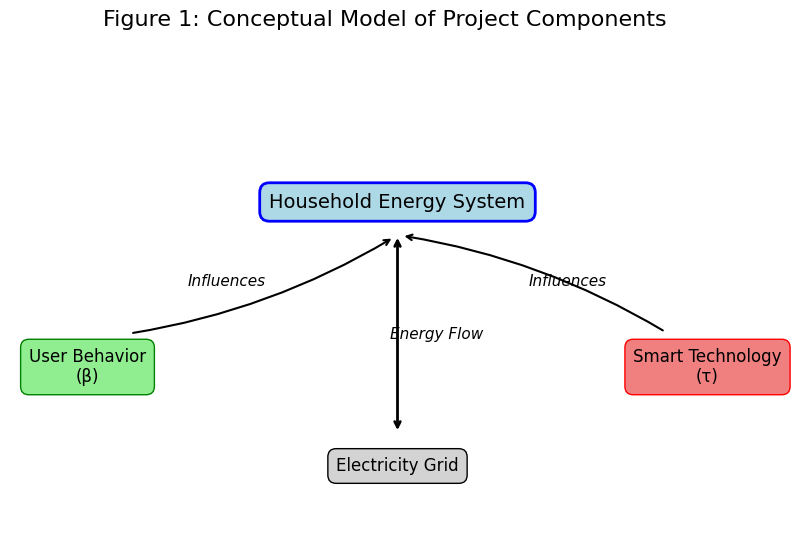

In [5]:
# Create a figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis('off') # Hiding the axes

# Defining properties for boxes and arrows
box_props = dict(boxstyle='round,pad=0.5', fc='lightblue', ec='b', lw=2)
arrow_props = dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', shrinkA=5, shrinkB=5,
                   patchA=None, patchB=None, color='black', lw=1.5)

# Drawing the main components
ax.text(5, 5, 'Household Energy System', ha='center', va='center', bbox=box_props, fontsize=14)
ax.text(1, 2.5, 'User Behavior\n(β)', ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', ec='g'), fontsize=12)
ax.text(9, 2.5, 'Smart Technology\n(τ)', ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', fc='lightcoral', ec='r'), fontsize=12)
ax.text(5, 1, 'Electricity Grid', ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', fc='lightgrey', ec='k'), fontsize=12)

# Drawing arrows to show influences and interactions
ax.annotate('', xy=(5, 4.5), xytext=(1.5, 3), arrowprops=arrow_props)
ax.annotate('', xy=(5, 4.5), xytext=(8.5, 3), arrowprops=arrow_props)
ax.annotate('', xy=(5, 1.5), xytext=(5, 4.5), arrowprops=dict(arrowstyle='<->', color='black', lw=2))

# Adding labels for arrows
ax.text(2.8, 3.8, 'Influences', ha='center', va='center', fontsize=11, style='italic')
ax.text(7.2, 3.8, 'Influences', ha='center', va='center', fontsize=11, style='italic')
ax.text(5.5, 3, 'Energy Flow', ha='center', va='center', fontsize=11, style='italic')

# Setting title and displaying the figure
fig.suptitle("Figure 1: Conceptual Model of Project Components", fontsize=16)
plt.show()



Synopsis: Data and Parameter Definition

This section defines and structures all input parameters for the optimization model. It performs the following tasks:
1. Sets the simulation time horizon.
2. Creates hourly baseline demand profiles for lighting and water heating.
3. Defines behavioral (β) and technological (τ) multipliers for each scenario.
4. Sets economic and environmental factors, including Time-of-Use tariffs, a peak demand penalty, and a CO₂ emissions factor.

This centralized parameter setup facilitates easy modification and scenario analysis.

Section 2: Data and Parameter Definition

In [6]:
# --- 2.1 Time Horizon Definition (Set T) ---
# Defining the set T from the methodology.
# A simulation period of 30 days is chosen for testing and annual projection.
SIMULATION_DAYS = 30
TIME_HORIZON = 24 * SIMULATION_DAYS
time_index = pd.to_datetime(pd.date_range(start='2025-01-01', periods=TIME_HORIZON, freq='h', name="time"))
print(f"Section 2: Data setup for a {SIMULATION_DAYS}-day ({TIME_HORIZON}-hour) simulation.")

# --- 2.2 Baseline Demand Profiles (Parameter D_j,t^base) ---
# Creating synthetic hourly demand profiles for a typical German household.
np.random.seed(42) # for reproducible randomness

# Lighting Demand Profile
lighting_baseline = np.sin(np.linspace(0, 2 * np.pi, 24)) * -0.4 + 0.5
lighting_baseline = np.tile(lighting_baseline, TIME_HORIZON // 24)
lighting_baseline[lighting_baseline < 0.05] = 0.05

# Water Heating Demand Profile
water_heating_baseline = (np.sin(np.linspace(0, 4 * np.pi, 24)) * -0.8 + 1.0)
water_heating_baseline = np.tile(water_heating_baseline, TIME_HORIZON // 24)

# Combining into a pandas DataFrame.
baseline_demand_df = pd.DataFrame({
    'lighting': lighting_baseline,
    'water_heating': water_heating_baseline
}, index=time_index)

# --- 2.3 Scenario Construction (Parameters β and τ) ---
# Defining the behavioral and technological multipliers for each scenario.
scenario_parameters = {
    'A_Baseline':        {'β': 1.2, 'τ': 0.0},
    'B_EfficientBehavior': {'β': 0.8, 'τ': 0.0},
    'C_SmartTechnology':   {'β': 1.2, 'τ': 0.3},
    'D_Combined':          {'β': 0.8, 'τ': 0.3}
}

# --- 2.4 Economic and Environmental Parameters ---
# Defining cost and emissions data.

# Time-of-Use (ToU) Tariff (Parameter C_t^ToU)
tou_tariff = pd.Series(0.20, index=time_index) # Off-peak rate
tou_tariff[tou_tariff.index.hour.isin(range(7, 11))] = 0.35 # Morning peak rate
tou_tariff[tou_tariff.index.hour.isin(range(17, 21))] = 0.45 # Evening peak rate

# Peak Demand Penalty (Parameter C^peak)
peak_penalty_cost = 50.0 # €/kW per year.
peak_penalty_cost_scaled = peak_penalty_cost * (SIMULATION_DAYS / 365)


# CO₂ Emissions Factor (Parameter E_grid)
co2_intensity_factor = 0.4 # kgCO₂/kWh

print("Section 2: All data and parameters have been defined.")


Section 2: Data setup for a 30-day (720-hour) simulation.
Section 2: All data and parameters have been defined.


Section 3: Optimization Model Function

This section contains the core function that builds and solves the linopy optimization model, implementing the mathematical formulation from the report.

In [7]:
def run_household_energy_simulation(scenario_name, params):
    """
    Builds, solves, and analyzes the energy model for a given scenario.

    This function defines the decision variables, constraints, and objective
    function to find the cost-optimal energy consumption pattern.

    Args:
        scenario_name (str): The name of the scenario being run.
        params (dict): A dictionary containing 'β' and 'τ' parameters.

    Returns:
        dict: A dictionary containing the simulation results.
    """
    print(f"\n--- Running optimization for Scenario: {scenario_name} ---")

    # Step 3.1: Initialize a new linopy Model instance
    model = linopy.Model()

    # Step 3.2: Calculate Adjusted Demand based on scenario parameters
    beta = params['β']
    tau = params['τ']
    adjusted_demand = baseline_demand_df.sum(axis=1) * beta * (1 - tau)
    adjusted_demand.name = "Adjusted Demand (kWh)"

    # Step 3.3: Define Decision Variables (P_t^grid and P^peak)
    grid_supply = model.add_variables(lower=0, coords=[time_index], name='grid_supply')
    peak_demand = model.add_variables(lower=0, name='peak_demand')

    # Step 3.4: Define Constraints based on the mathematical formulation
    model.add_constraints(grid_supply == adjusted_demand, name="energy_balance_constraint")
    model.add_constraints(peak_demand >= grid_supply, name="peak_definition_constraint")

    # Step 3.5: Define the Objective Function for cost minimization
    total_energy_cost = (grid_supply * tou_tariff).sum()
    peak_demand_penalty = peak_demand * peak_penalty_cost_scaled
    total_cost_objective = total_energy_cost + peak_demand_penalty
    model.add_objective(total_cost_objective)

    # Step 3.6: Solve the Optimization Problem
    model.solve()
    print(f"Solver status: {model.status}")

    # Step 3.7: Collect and Return Key Results
    results = {
        'Scenario': scenario_name,
        'Total Cost (€)': model.objective.value,
        'Energy Cost (€)': (model.solution['grid_supply'] * tou_tariff).sum().item(),
        'Peak Cost (€)': model.solution['peak_demand'].item() * peak_penalty_cost_scaled,
        'Total Emissions (kgCO2)': (model.solution['grid_supply'].sum() * co2_intensity_factor).item(),
        'Peak Usage (kW)': model.solution['peak_demand'].item(),
        'Hourly Supply (kWh)': model.solution['grid_supply'].to_pandas()
    }
    
    return results

print("Section 3: Optimization model function defined.")

Section 3: Optimization model function defined.


Section 4: Simulation Execution
This section iterates through all defined scenarios, calls the simulation function, and stores the results.

In [8]:
print("\nSection 4: Starting scenario simulations...")
all_results = []
for name, params in scenario_parameters.items():
    scenario_result = run_household_energy_simulation(name, params)
    all_results.append(scenario_result)

# Converting the list of result dictionaries into a pandas DataFrame
results_summary_df = pd.DataFrame(all_results).set_index('Scenario')

# Separating the hourly supply data for plotting
hourly_supply_data = {res['Scenario']: res.pop('Hourly Supply (kWh)') for res in all_results}

print("\nSection 4: All scenarios have been simulated successfully.")



Section 4: Starting scenario simulations...

--- Running optimization for Scenario: A_Baseline ---
Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file C:\Users\linus\AppData\Local\Temp\linopy-problem-06pwulhu.lp
Reading time = 0.00 seconds
obj: 1440 rows, 721 columns, 2160 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11+.0 (26120.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1440 rows, 721 columns and 2160 nonzeros
Model fingerprint: 0xf393bf02
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+00]
Presolve removed 1440 rows and 721 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
 

Section 5: Results Visualization

 This section generates the plots and tables for the report.


Section 5: Generating results and visualizations...

--- Summary of Simulation Results for 30 Days ---


,Total Cost (€),Total Emissions (kgCO2),Peak Usage (kW)
Scenario,,,
A_Baseline,394.43,518.40,3.11
B_EfficientBehavior,262.95,345.60,2.07
C_SmartTechnology,276.10,362.88,2.18
D_Combined,184.07,241.92,1.45


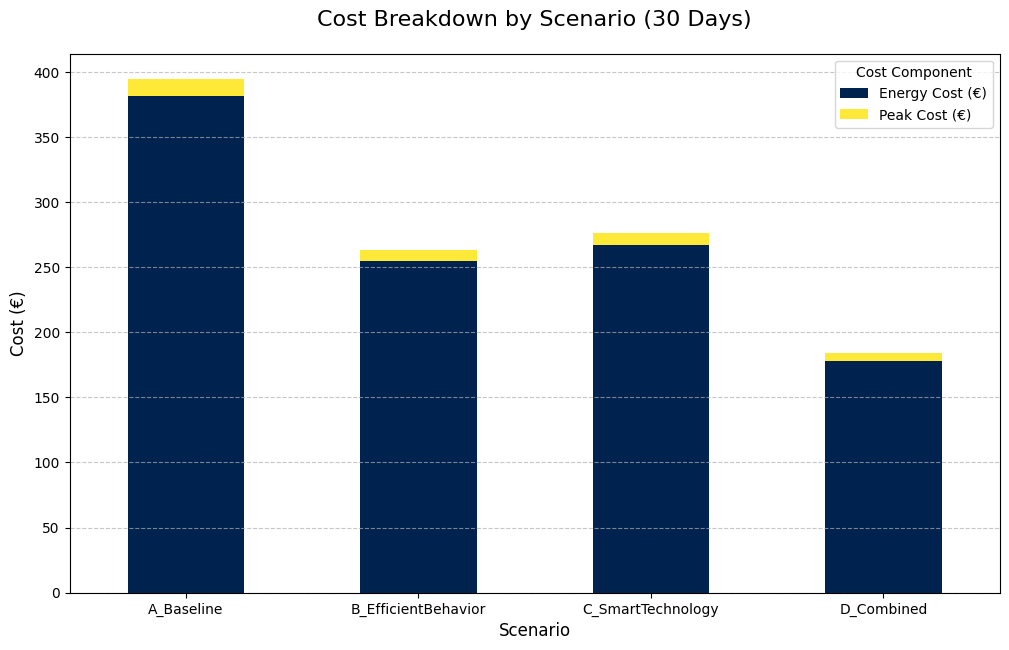


Section 5: Report visualizations are complete.


In [9]:
print("\nSection 5: Generating results and visualizations...")

# --- 5.1 Display Summary Table of Results ---
print(f"\n--- Summary of Simulation Results for {SIMULATION_DAYS} Days ---")
display(results_summary_df[['Total Cost (€)', 'Total Emissions (kgCO2)', 'Peak Usage (kW)']].round(2))

# --- 5.2 Plot: Cost Analysis ---
cost_breakdown_df = results_summary_df[['Energy Cost (€)', 'Peak Cost (€)']]
ax = cost_breakdown_df.plot(kind='bar', stacked=True, figsize=(12, 7), rot=0, colormap='cividis')
ax.set_title(f'Cost Breakdown by Scenario ({SIMULATION_DAYS} Days)', fontsize=16, pad=20)
ax.set_ylabel('Cost (€)', fontsize=12)
ax.set_xlabel('Scenario', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Cost Component')
plt.show()

# --- 5.3 Plot: Energy Usage Profiles ---
fig_daily = go.Figure()
for scenario_name, hourly_series in hourly_supply_data.items():
    fig_daily.add_trace(go.Scatter(
        x=hourly_series.index[:24], 
        y=hourly_series.values[:24], 
        mode='lines+markers', 
        name=scenario_name
    ))

fig_daily.update_layout(
    title='Comparative Daily Electricity Consumption Profile (First 24 Hours)',
    xaxis_title='Hour of the Day',
    yaxis_title='Electricity Consumption (kWh)',
    legend_title='Scenario',
    font=dict(size=12),
    template='plotly_white'
)
fig_daily.show()

print("\nSection 5: Report visualizations are complete.")

Section 6: Annual Savings Analysis

This section projects the simulation results to a full year to calculate and display the potential annual financial savings for each scenario.

In [10]:
print("\nSection 6: Calculating and Displaying Annual Savings...")

# Calculating the projected annual cost for each scenario
annual_projection_factor = 365 / SIMULATION_DAYS
projected_annual_cost = results_summary_df['Total Cost (€)'] * annual_projection_factor

# Getting the annual cost of the baseline scenario
baseline_annual_cost = projected_annual_cost.loc['A_Baseline']

# Calculating the annual savings for each scenario relative to the baseline
annual_savings = baseline_annual_cost - projected_annual_cost
percentage_savings = (annual_savings / baseline_annual_cost) * 100

# Creating a new DataFrame to display the savings analysis
savings_df = pd.DataFrame({
    'Projected Annual Cost (€)': projected_annual_cost,
    'Annual Savings vs. Baseline (€)': annual_savings,
    'Percentage Savings (%)': percentage_savings
})

# Displaying the formatted savings table
print("\n--- Projected Annual Savings Analysis ---")
display(savings_df.round(2))


Section 6: Calculating and Displaying Annual Savings...

--- Projected Annual Savings Analysis ---


,Projected Annual Cost (€),Annual Savings vs. Baseline (€),Percentage Savings (%)
Scenario,,,
A_Baseline,4798.93,0.00,0.00
B_EfficientBehavior,3199.28,1599.64,33.33
C_SmartTechnology,3359.25,1439.68,30.00
D_Combined,2239.50,2559.43,53.33
